In [1]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import warnings
import missingno as mno
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
le =LabelEncoder()
pd.set_option('display.max_columns', None)


In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# Data Preprocessing

## Handling missing values

In [3]:
train.isna().mean().sort_values()

child_id                  0.000000
pre_covid                 0.000000
sef_ind                   0.000000
language_assessment       0.000000
hle_ind                   0.000000
                            ...   
pra_class_space_small     0.998952
pri_founderother          0.999068
pri_clinic_travelother    0.999418
pri_locationother         0.999418
other_practitioner        0.999534
Length: 679, dtype: float64

<AxesSubplot:>

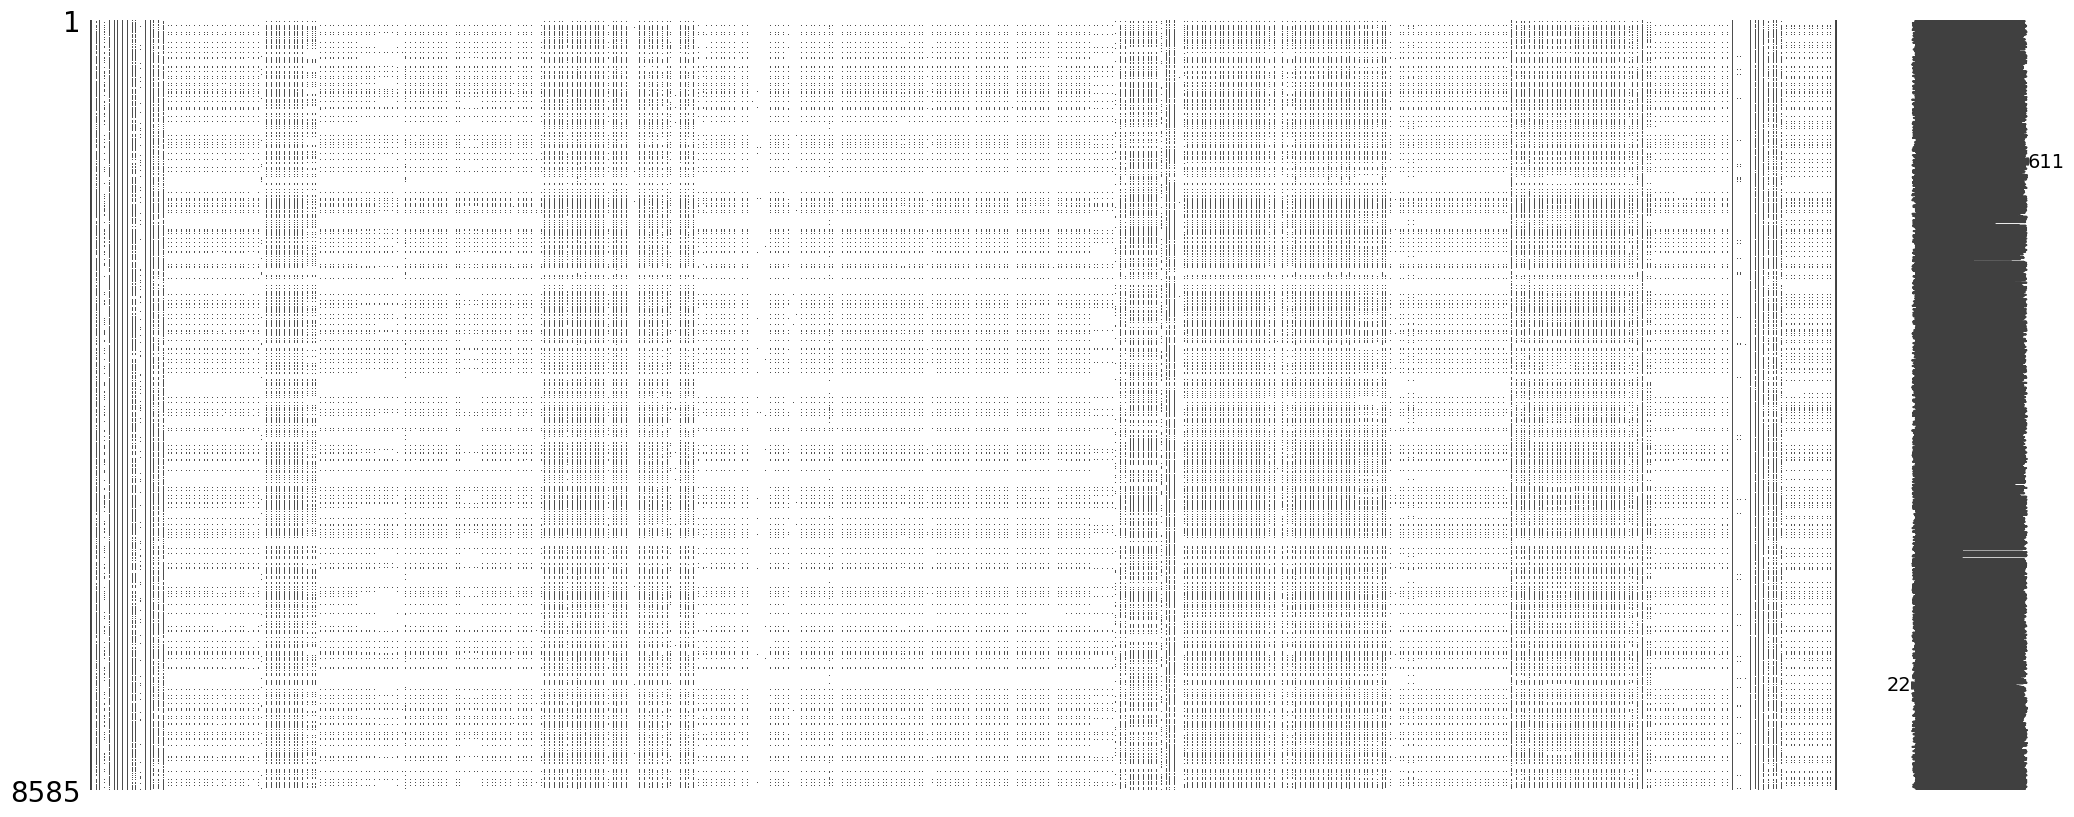

In [4]:
mno.matrix(train)

We can observe from the missingno plot that there are a large number of missing values in the dataset. Additionally, with over 600 columns, the data is high dimensional, which makes it prone to overfitting. To address this issue, we have decided to drop columns with more than 30% missing values. This approach helps us to reduce the dimensionality of the data while also removing any columns that may not contribute significantly to the model's performance. By doing so, we aim to improve the robustness and accuracy of the model.

In [5]:

def train_test(train, test, to_keep, to_delete):
    missing = train.isna().mean()
    # Drop columns with more than 30% missing values
    train = train.drop(columns=[e for e in list(missing[missing > 0.3].index) if e not in to_keep], axis=1)
    train = train.drop(to_delete,axis=1)
    
    features = train.columns
    test = test[features.drop("target")]
    train["train"] = 1
    test["train"] = 0
    train_test = pd.concat([train,test]).reset_index(drop=True)
    return train_test


 Despite having more than 30% missing values, we have chosen to keep certain columns like 'id_team' and 'longitude' and 'latitude' as they seem to be important features that can significantly impact the performance of the model. On the other hand, we have also decided to delete certain columns like 'child_date_of_birth' as it adds no additional information when we already have the 'child_age' column. We have also removed duplicated columns like 'id_prov' as it is the same as 'prov_best' etc. 

By carefully selecting the columns to keep and delete, we aim to improve the quality of the data and ensure that the model is not overfitting. This will also help us obtain more accurate results from the model.


In [6]:
to_keep =['latitude','longitude',"id_team"]
to_delete = ["dc_best","mn_best","id_prov","language_child","child_dob","child_id","language_match"]

In [7]:
# final train and test dataset merged
train_test = train_test(train, test, to_keep, to_delete)

# Feature engineering

In this section, we will perform various operations to create new features or modify existing features from our dataset. The goal of feature engineering is to extract useful information from the raw data and transform it into a form that can be easily used by the machine learning algorithms. This process can involve creating new features, transforming existing features, and removing irrelevant or redundant features.

By carefully engineering the features, we aim to improve the performance of the model and increase its accuracy. In this section, we will perform various operations such as scaling, normalization, and encoding to prepare the data for modeling. 



## id_ward

In [8]:
# Defining the geographical variables

geo = ["prov_best","id_dc_best","id_mn_best","id_ward"]

# Creating a list of unique values of the 'id_ward' column and removing any missing values
wards = np.delete(train_test["id_ward"].unique(), pd.isna(train_test["id_ward"].unique()))

# Looping through each unique value in the 'wards' list
for ward in wards:
    # Subsetting the data to only include rows where 'id_ward' is equal to the current value in the loop
    df = train_test.loc[train_test["id_ward"]==ward,geo]
    
    # If there are any missing values in the subsetted data and there are also non-missing values
    if df.isna().any().any() and len(df.dropna())>0:
        # Replace missing values with the first non-missing value
        df[df.isnull().any(axis=1)] = df[~df.isnull().any(axis=1)].iloc[0]
        # Replace the subsetted data in the original dataframe with the filled data
        train_test.loc[train_test["id_ward"]==ward,geo] = df


The idea behind this code is to fill in missing values for the id_mn_best, id_dc_best, and prov_best variables by assuming that the values for these variables are the same for all rows with the same id_ward value. The code does this by looping through each unique value of the id_ward column and for each value, it subsets the data to only include rows where id_ward is equal to that value. If there are any missing values in the subsetted data and there are also non-missing values, the missing values are filled in with the first non-missing value. The filled data is then used to replace the subsetted data in the original train_test dataframe. This process is repeated for each unique value of id_ward.

### child years in programme

In [9]:
train["child_years_in_programme"].value_counts()

1st year in the programme    4369
2nd year in programme        1917
3rd year in programme        1485
Do Not Know                   108
Name: child_years_in_programme, dtype: int64

In [10]:
train_test["child_years_in_programme"].fillna("Do Not Know",inplace=True) # replace missinf values by do not  know
encoding = {'1st year in the programme':1, '2nd year in programme':2,
            '3rd year in programme':3, "Do Not Know":1 }
train_test["child_years_in_programme"] = train_test["child_years_in_programme"].apply(lambda x: encoding[x])


### unique programmes years

In [11]:
# Filling in missing values for the 'id_facility' variable with -1
train_test["id_facility"] = train_test["id_facility"].fillna(-1)

# Counting the number of unique values of the 'child_years_in_programme' variable for each unique value of 'id_facility'
s = train_test.groupby("id_facility")["child_years_in_programme"].nunique()

# Mapping the count of unique values to the 'id_facility' variable and creating a new column 'child_years_in_programme_unique_facility'
train_test["child_years_in_programme_unique_facility"] = train_test["id_facility"].map(s)

# Counting the number of unique values of the 'child_years_in_programme' variable for each unique value of 'id_enumerator'
s = train_test.groupby("id_enumerator")["child_years_in_programme"].nunique()

# Mapping the count of unique values to the 'id_enumerator' variable and creating a new column 'child_years_in_programme_unique_enumerator'
train_test["child_years_in_programme_unique_enumerator"] = train_test["id_enumerator"].map(s)


### number of occurrences of each unique value of the 'id_facility', 'id_mn_best', 'id_dc_best', and 'prov_best' variables


In [12]:
# Counting the number of occurrences of each unique value of the 'id_facility', 'id_mn_best',
#'id_dc_best' and 'prov_best' variables

n_facility = train_test.id_facility.value_counts()
n_id_mn_best = train_test.id_mn_best.value_counts()
n_id_dc_best = train_test.id_dc_best.value_counts()
n_prov_best = train_test.prov_best.value_counts()


# Mapping the count of occurrences
train_test["n_facility"] = train_test["id_facility"].map(n_facility)
train_test["n_id_mn_best"] = train_test["id_mn_best"].map(n_id_mn_best)
train_test["n_id_dc_best"] = train_test["id_dc_best"].map(n_id_dc_best)
train_test["n_prov_best"] = train_test["prov_best"].map(n_prov_best)

### number of spoken languages by the enumerator 


In [13]:
n_lang = train_test.groupby("id_enumerator")["language_assessment"].nunique()
train_test["enumerator_spoken_languages"] = train_test["id_enumerator"].map(n_lang)
train_test["enumerator_spoken_languages_class"] = train_test["enumerator_spoken_languages"].apply(lambda x: 0 if x==1
                                                                                                 else(1 if x==2 else 2))


### target encoding of language_assessment and prov_best

 Target encoding replaces the categorical variables with their mean target value. This can help to reduce the dimensionality of the data, especially when the number of unique values in the categorical variables is high. One-hot encoding, on the other hand, creates a new binary column for each unique value in the categorical variables. This can lead to an increase in the number of columns and the dimensionality of the data. In this case, the choice of target encoding is made to prevent amplifying the data dimension as the data is already high dimensional.

In [14]:
# As our data is already high dimensional we opt for target encoding to not amplify our data dimension
mean = train_test.groupby('prov_best').target.mean()
train_test['prov_best'] = train_test["prov_best"].map(mean)

std = train_test.groupby('language_assessment').target.std()
train_test['language_assessment'] = train_test["language_assessment"].map(std)


### child characteristics

In [15]:
characteristics = ["child_observe_attentive", "child_observe_concentrated", "child_observe_diligent",
                   "child_observe_interested"]
overall_characteristic = "child_observe_total"
encoding = {"Almost never":0, "Sometimes":1, "Often":2,"Almost always":3} 

train_test[characteristics] = train_test[characteristics].applymap(lambda x: encoding[x])
train_test[overall_characteristic] = train_test[characteristics].sum(axis=1)

# the variablity of characteristics for each child
train_test["var_char"] = train_test[["child_observe_attentive","child_observe_concentrated","child_observe_diligent","child_observe_interested"]].apply(lambda train_test: train_test.var(),axis=1)

### child date

 The code extracts various time-based features from the child_date column and creates new columns for each feature. The purpose is to capture information about the time component of the data, which may have a relationship with the target variable, and improve the performance of a machine learning model.

In [16]:
col_name = "child_date"
train_test[col_name] = pd.to_datetime(train_test[col_name])

train_test[col_name+'dayofyear'] = train_test[col_name].dt.dayofyear
train_test[col_name+'dayofweek'] = train_test[col_name].dt.dayofweek
train_test[col_name+'quarter'] = train_test[col_name].dt.quarter
train_test[col_name+'weekofyear'] = train_test[col_name].dt.weekofyear
train_test[col_name] = train_test[col_name].dt.month

### child_age

In [17]:
print(train_test["child_age_group"].unique())
encoding = {'Younger than 50 months': 1, '50-59 months' : 1,'60-69 months': 2, '70 Months or older' :2}
train_test["child_age_group"] = train_test["child_age_group"].apply(lambda x: encoding[x])

['50-59 months' '60-69 months' '70 Months or older'
 'Younger than 50 months']


### missing values of id_enumerator and the remaining missing values of id_ward


The idea behind the following code is to fill the missing values in the id_enumerator and id_ward columns. The code does this by replacing the missing values with negative values of the id_facility column for the same rows in the case of id_enumerator, and negative values of the same id_ward column in the case of id_ward.

The purpose of this transformation is to provide some information for the missing values. By replacing missing values with negative values, the code is preserving the information that the values are missing, while also providing some information about the relationship between the missing values and other variables in the data. We supposed that each facility has its own and unique enumerator and id_ward.

In [18]:
mask = pd.isna(train_test["id_enumerator"])
train_test.loc[mask,["id_enumerator"]] = - train_test[pd.isna(train_test["id_enumerator"])]["id_facility"]

mask = pd.isna(train_test["id_ward"])
train_test.loc[mask,["id_ward"]] = - train_test[pd.isna(train_test["id_ward"])]["id_ward"]

## Label encoding:

In [19]:
# encode categorical columns 
def label_encode_columns(df, columns):
    le = LabelEncoder()
    for col in columns:
        not_null = df[col].notnull()
        df.loc[not_null, col] = le.fit_transform(df.loc[not_null, col].astype(str))
    return df

cat_cols = list(train_test.select_dtypes(include='object'))
train_test = label_encode_columns(train_test, cat_cols)

# Base model
now moving on to the awsome part of machine learning, building model!

In [20]:
#train_test split
train1 = train_test[train_test.train==1].drop("train",axis=1)
test1 = train_test[train_test.train==0].drop(["train","target"],axis=1)
X1 = train1.drop("target",axis=1)
y1 = train1.target


In [21]:
#model:
from catboost import CatBoostRegressor
X_train, X_test , y_train, y_test = train_test_split(X1, y1,test_size=0.2, random_state=1)

model =  CatBoostRegressor(iterations=1500, learning_rate=0.05, depth=5,colsample_bylevel=0.7, l2_leaf_reg=10, random_seed=0,verbose=100)
model.fit(X1, y1, eval_set=[ (X_test, y_test)], verbose=200)

0:	learn: 14.9332630	test: 14.8506799	best: 14.8506799 (0)	total: 145ms	remaining: 3m 37s
200:	learn: 10.0618890	test: 10.1940735	best: 10.1940735 (200)	total: 1.24s	remaining: 7.99s
400:	learn: 9.2704298	test: 9.3219549	best: 9.3219549 (400)	total: 2.4s	remaining: 6.58s
600:	learn: 8.8061627	test: 8.8319969	best: 8.8319969 (600)	total: 3.66s	remaining: 5.48s
800:	learn: 8.4662138	test: 8.4664878	best: 8.4664878 (800)	total: 4.92s	remaining: 4.3s
1000:	learn: 8.1982740	test: 8.1853544	best: 8.1853544 (1000)	total: 6.15s	remaining: 3.07s
1200:	learn: 7.9727968	test: 7.9476279	best: 7.9476279 (1200)	total: 7.28s	remaining: 1.81s
1400:	learn: 7.7542554	test: 7.7100254	best: 7.7100254 (1400)	total: 8.52s	remaining: 602ms
1499:	learn: 7.6543134	test: 7.6048621	best: 7.6048621 (1499)	total: 8.96s	remaining: 0us

bestTest = 7.604862111
bestIteration = 1499



Text(0.5, 1.0, 'Feature Importance')

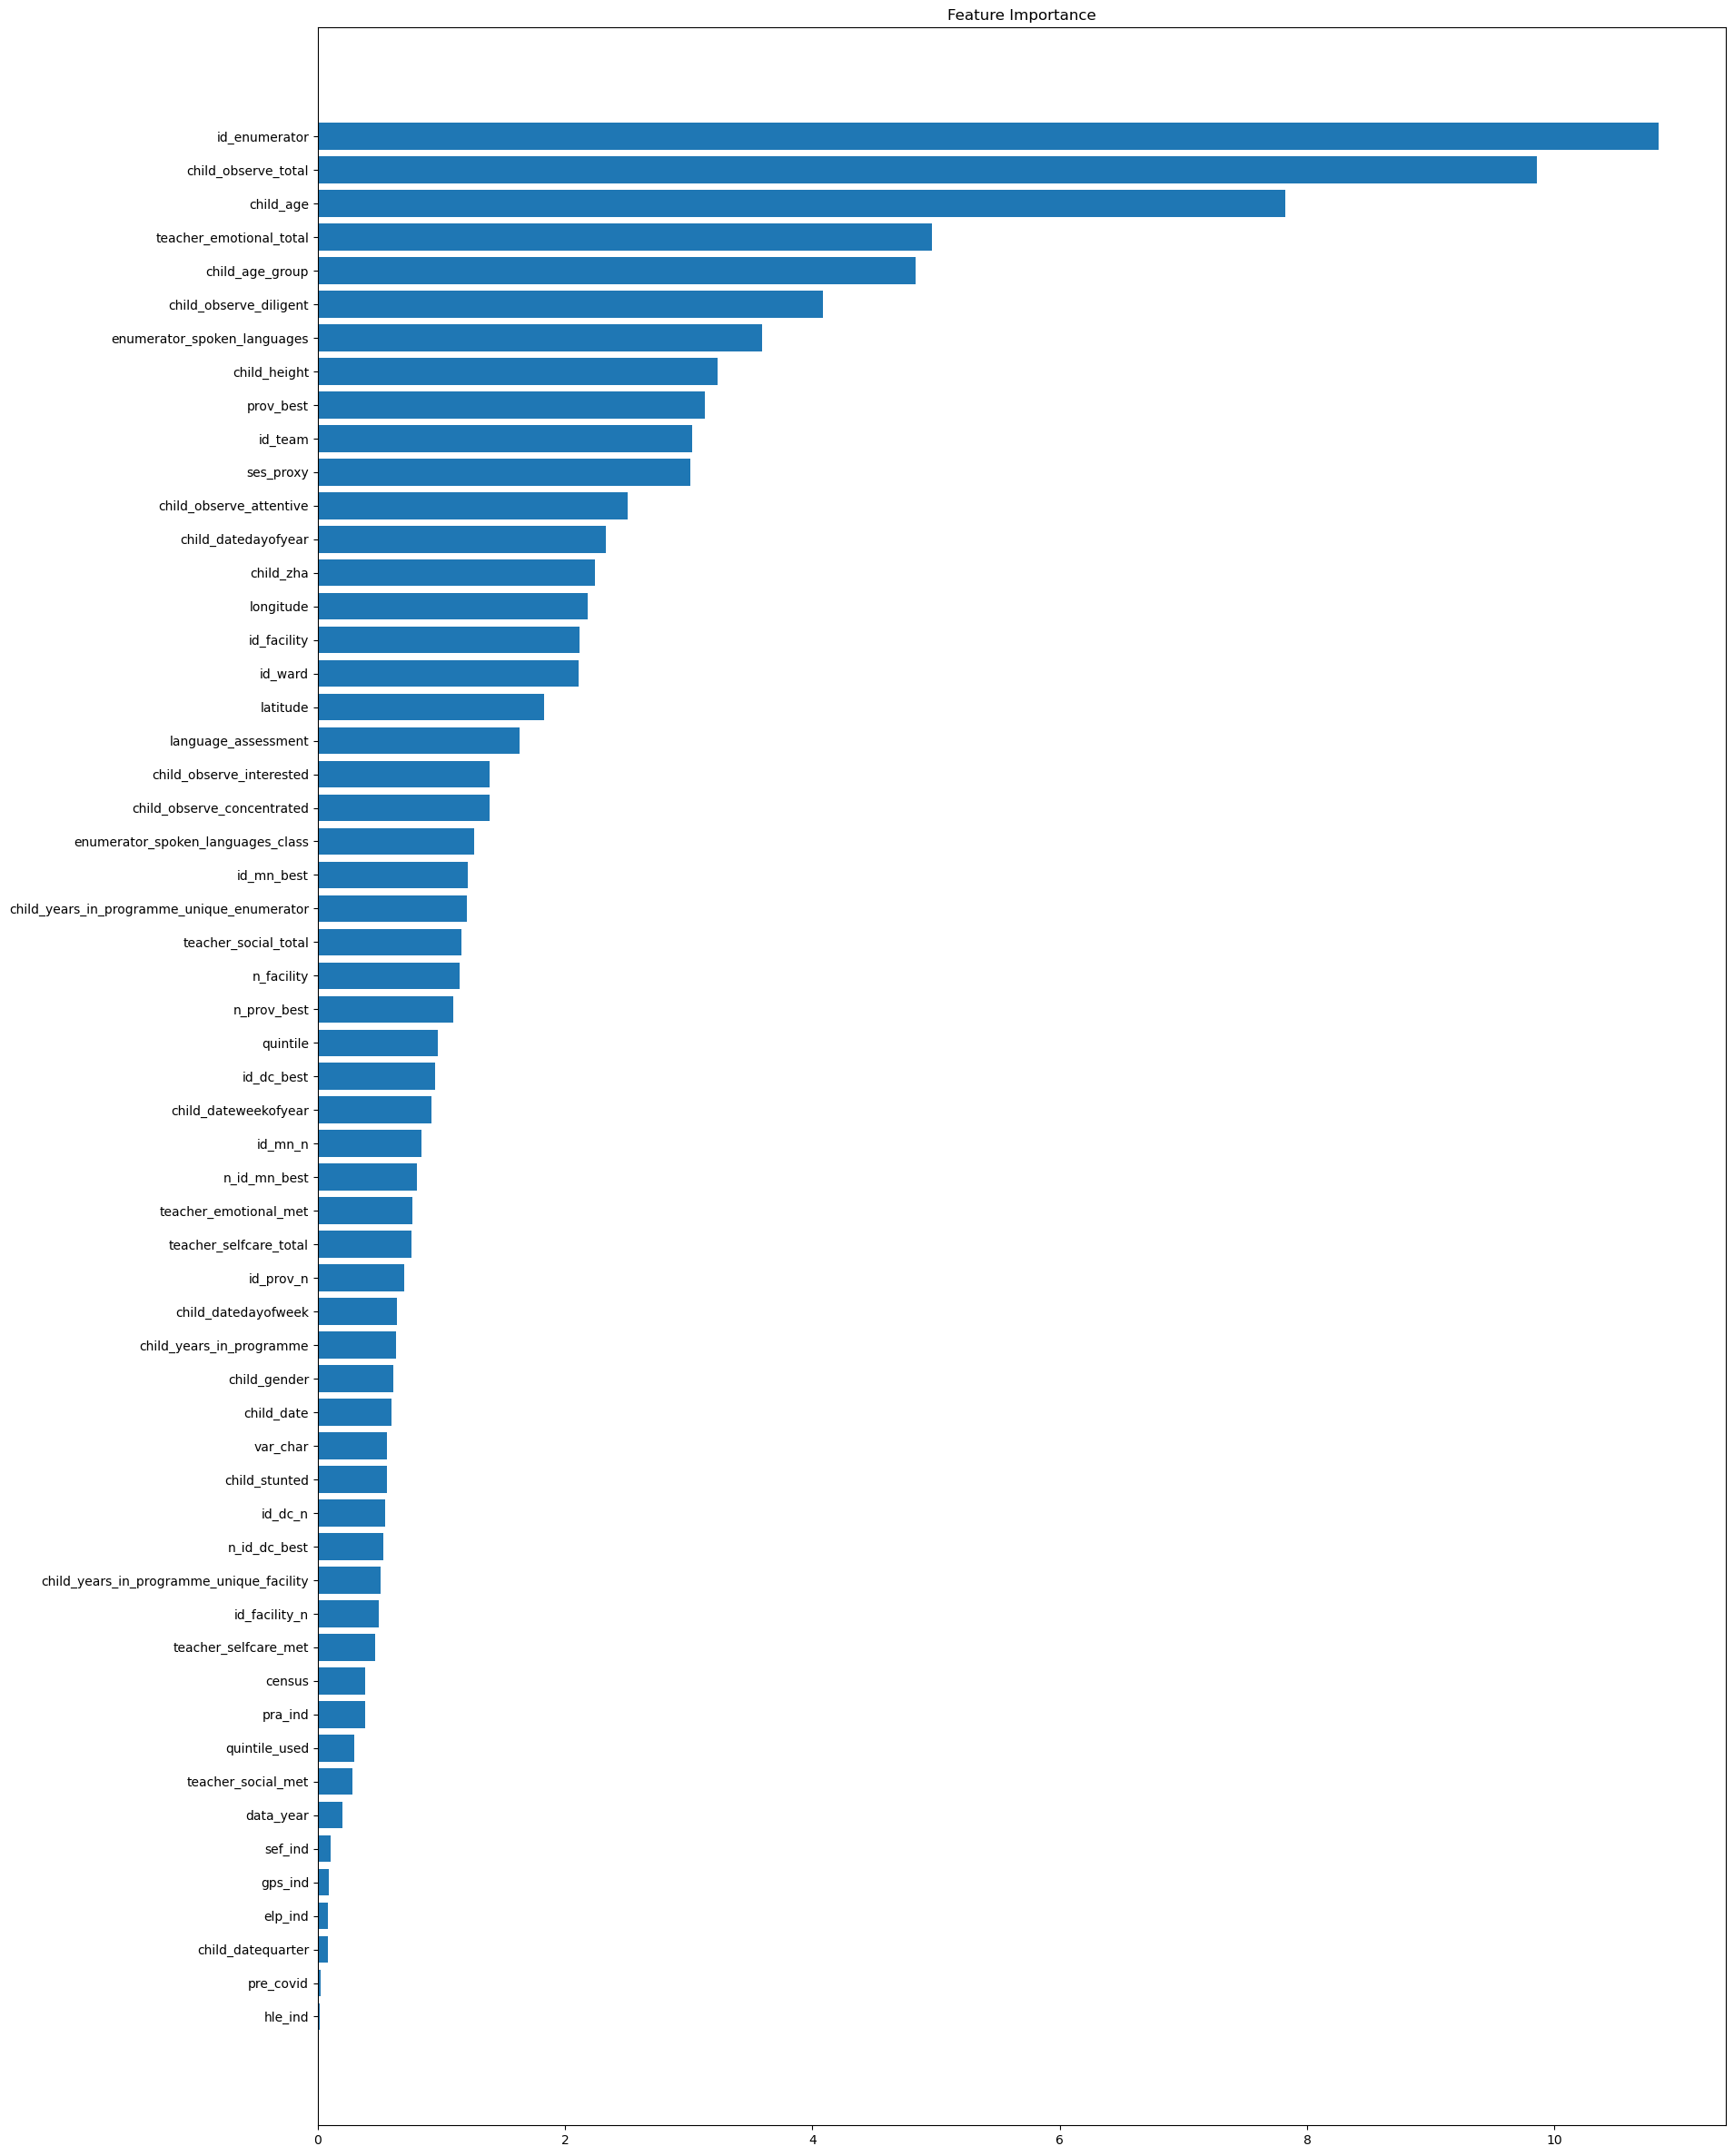

In [22]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(20, 30))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

**The id_enumerator column has been found to be the most important feature in the analysis, despite being a categorical feature that has been label encoded. This is surprising as it has more importance than the child characteristics. This suggests that the id_enumerator column contains a lot of valuable information that can be exploited.**

**Each enumerator may have their own specificities when it comes to assessing children, for example, some may be easier on them or more biased than others. However, without enough information or context, it is not possible to determine this with certainty. However, it is possible to create new, useful features by aggregating statistics based on the id_enumerator column. This can provide additional information about the relationship between the enumerator and the children they assess, which may further improve the performance of a machine learning model.**

## Additional feature engineering

The following code aggregates various statistics for columns based on the id_enumerator column, creating new features that capture information about the distribution of the data, the range of values, and the central tendency. This information can help to improve the performance of a machine learning model by providing a summary of the data for each id_enumerator. The new features are created by mapping the aggregated statistics to the id_enumerator column in the train_test dataframe.

In [23]:
# latitude
id_ = train.groupby("id_enumerator").latitude.mean()
train_test["id_enumerator_lat"] = train_test["id_enumerator"].map(id_)
# longitude
id_ = train.groupby("id_enumerator").longitude.mean()
train_test["id_enumerator_lon"] = train_test["id_enumerator"].map(id_)

# columns to be aggrgated based on the feature importance plot
cols = ["child_observe_total","child_years_in_programme","child_age","child_age_group","teacher_emotional_total"]
for col in cols:   
    std = train_test.groupby("id_enumerator")[col].std()
    count = train_test.groupby("id_enumerator")[col].count()
    mean = train_test.groupby("id_enumerator")[col].mean()
    min_ = train_test.groupby("id_enumerator")[col].min()
    max_ = train_test.groupby("id_enumerator")[col].max()
    mad = train_test.groupby("id_enumerator")[col].apply(lambda x: abs(x - x.mean()).mean())

    train_test["std_"+col] = train_test["id_enumerator"].map(std)
    train_test["count_"+col] = train_test["id_enumerator"].map(count)
    train_test["mean_"+col] = train_test["id_enumerator"].map(mean)
    train_test["min_"+col] = train_test["id_enumerator"].map(min_)
    train_test["max_"+col] = train_test["id_enumerator"].map(max_)
    train_test["mad_"+col] = train_test["id_enumerator"].map(mad)


## autofeat

autofeat is a package for feature engineering in machine learning. It generates new features by trying different mathematical operations and transformations on existing features. This process can help to identify new features that may improve the performance of a machine learning model.

Please uncomment the following code to try autofeat yourself. We have run it several times and selected the features that we believe to be important. It's important to note that autofeat often generates highly correlated features, which can harm the performance of a machine learning model if not carefully selected

In [24]:
"""
import autofeat
cols = ['child_age','ses_proxy',
       'child_height','child_observe_total','child_age_group','teacher_social_total',
       'teacher_emotional_total',
       'std_child_observe_total', 'mean_child_observe_total','mean_child_age','mad_child_age','mean_teacher_emotional_total',
       'mad_teacher_emotional_total']

# Generate new features
new_features = autofeat.AutoFeatRegressor( transformations=["1/", "exp", "log", "abs", "sqrt", "^2", "1+", "1-", "exp-", "2^"],n_jobs=-1, featsel_runs=8, feateng_cols=cols,
                                         verbose=1,feateng_steps=3)
new_features.fit(X, y)
transformed_data = new_features.transform(X)

# View the resulting data with the new features
print(transformed_data.head())
"""

'\nimport autofeat\ncols = [\'child_age\',\'ses_proxy\',\n       \'child_height\',\'child_observe_total\',\'child_age_group\',\'teacher_social_total\',\n       \'teacher_emotional_total\',\n       \'std_child_observe_total\', \'mean_child_observe_total\',\'mean_child_age\',\'mad_child_age\',\'mean_teacher_emotional_total\',\n       \'mad_teacher_emotional_total\']\n\n# Generate new features\nnew_features = autofeat.AutoFeatRegressor( transformations=["1/", "exp", "log", "abs", "sqrt", "^2", "1+", "1-", "exp-", "2^"],n_jobs=-1, featsel_runs=8, feateng_cols=cols,\n                                         verbose=1,feateng_steps=3)\nnew_features.fit(X, y)\ntransformed_data = new_features.transform(X)\n\n# View the resulting data with the new features\nprint(transformed_data.head())\n'

In [25]:
train_test["child_age**2sqrt(child_observe_total)"] = (train_test["child_age"]**2) * np.sqrt(train_test["child_observe_total"]) 
train_test["exp(-child_observe_total/mean_child_observe_total)"] = np.exp(-train_test["child_observe_total"]/train_test["mean_child_observe_total"])
train_test["child_observe_total**2*ses_proxy"] = train_test["child_observe_total"]**2 * train_test["ses_proxy"] 
train_test["mean_child_age**2*sqrt(teacher_emotional_total)"] = train_test["mean_child_age"]**2 * np.sqrt(train_test["teacher_emotional_total"])

## filling missing values

In [26]:
# filling missing values
mean_filled = train_test.groupby("id_enumerator").transform(lambda x: x.fillna(x.mean()))
train_test.update(mean_filled)

train_test = train_test.fillna(-10)


## split data to train and test

In [27]:
train = train_test[train_test.train==1].drop("train",axis=1)
test = train_test[train_test.train==0].drop(["train","target"],axis=1)
X = train.drop("target",axis=1)
y = train.target


# Hyperparameters tunning 

Please uncomment the following code if you want to try yourself different hyperparameters tunning values, However it will take a long time to run, thus we commented the code and provided the tunned parameters directly for fast prototyping.

The following code is implementing a hyperparameter tuning procedure for an XGBoost regression model. The goal is to find the optimal set of hyperparameters for the model that result in the best performance.

The code starts by defining the base XGBoost model, and specifying a search space for the hyperparameters. The search space is defined using the hyperopt library, and includes a range of possible values for each hyperparameter.

Next, an objective function is defined which takes in the hyperparameters and the data, fits the XGBoost model with the given hyperparameters, and calculates a mean squared error score using 10-fold cross validation. The objective function is meant to be minimized, so a negative mean squared error score is used to reflect this.

Finally, the hyperparameter tuning procedure is performed using the Hyperopt library's Tree-structured Parzen Estimator (TPE) algorithm. The algorithm is run for 300 evaluations, and the best set of hyperparameters is stored in a dictionary called best_params_dict. The final XGBoost model with the best hyperparameters is fit to the data and stored in a dictionary called tuned_models.

In [28]:
"""
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer
from functools import partial
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
import hyperopt

# Define base models
base_model = {
'xgboost': xgb.XGBRegressor(random_state=0, n_jobs=-1)
}

# Define hyperparameter search spaces
search_spaces = {
        'max_depth': hp.choice('max_depth', np.arange(4, 7)),
        'learning_rate':hp.uniform('learning_rate', 0.02, 0.08),
        'n_estimators': hp.choice('n_estimators', np.arange(300, 1300, 50)),
        'min_child_weight': hp.uniform('min_child_weight', 0.1, 10),
        'gamma': hp.uniform('gamma', 0, 5),
        'subsample': hp.uniform('subsample', 0.1, 1),
        'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 0.8),
        'colsample_bylevel': hp.uniform('colsample_bylevel', 0.1, 0.8),
        'colsample_bynode': hp.uniform('colsample_bynode', 0.1, 0.8),
        'grow_policy': hp.choice('grow_policy ', ["depthwise", 'lossguide']),
        'reg_alpha': hp.uniform('reg_alpha', 0, 5),
        'max_bin': hp.choice('max_bin ', [256, 512]),
        'num_parallel_tree': hp.choice('num_parallel_tree ', np.arange(1, 5)),
        'reg_lambda': hp.uniform('reg_lambda', 4, 15),
    }

# Define the objective function for hyperopt
def objective_func(params, model, X, y, scoring, cv):
    model.set_params(**params)
    score = np.mean(np.sqrt(-cross_val_score(model, X, y, scoring=scoring, cv=cv, n_jobs=-1)))
    return {'loss': score, 'status': STATUS_OK}

best_params_dict = {}  # Create an empty dictionary to store the best parameters

# Perform TPE hyperparameter search and save the best models
tuned_models = {}
for model_name, model in base_model.items():
    print(f"Fine-tuning {model_name}")
    obj_func = partial(objective_func, model=model, X=X, y=y, scoring=make_scorer(mean_squared_error, greater_is_better=False), cv=10)
    trials = Trials()
    best_params = fmin(obj_func, search_spaces, algo=tpe.suggest, max_evals=300, trials=trials, verbose=1)

    # Update the best_params with the actual parameter values
    best_params = hyperopt.space_eval(search_spaces, best_params)
    
     # Store the best parameters in the dictionary
    best_params_dict[model_name] = best_params

    model.set_params(**best_params)
    model.fit(X, y)
    tuned_models[model_name] = model
    break
"""


'\nimport xgboost as xgb\nfrom sklearn.model_selection import train_test_split, cross_val_score\nfrom sklearn.metrics import mean_squared_error, make_scorer\nfrom functools import partial\nfrom hyperopt import fmin, tpe, hp, Trials, STATUS_OK\nimport hyperopt\n\n# Define base models\nbase_model = {\n\'xgboost\': xgb.XGBRegressor(random_state=0, n_jobs=-1)\n}\n\n# Define hyperparameter search spaces\nsearch_spaces = {\n        \'max_depth\': hp.choice(\'max_depth\', np.arange(4, 7)),\n        \'learning_rate\':hp.uniform(\'learning_rate\', 0.02, 0.08),\n        \'n_estimators\': hp.choice(\'n_estimators\', np.arange(300, 1300, 50)),\n        \'min_child_weight\': hp.uniform(\'min_child_weight\', 0.1, 10),\n        \'gamma\': hp.uniform(\'gamma\', 0, 5),\n        \'subsample\': hp.uniform(\'subsample\', 0.1, 1),\n        \'colsample_bytree\': hp.uniform(\'colsample_bytree\', 0.1, 0.8),\n        \'colsample_bylevel\': hp.uniform(\'colsample_bylevel\', 0.1, 0.8),\n        \'colsample_bynod

# xgboost with the optimal hyperparameters

In [29]:
xgb_params = {'colsample_bylevel': 0.25051616409947264,
 'colsample_bynode': 0.45852106271653026,
 'colsample_bytree': 0.49808749002297764,
 'gamma': 0.6715594182885887,
 'grow_policy': 'depthwise',
 'learning_rate': 0.04824020229975944,
 'max_bin': 256,
 'max_depth': 6,
 'min_child_weight': 3.79670969284859,
 'n_estimators': 700,
 'num_parallel_tree': 3,
 'reg_alpha': 2.7685173174786497,
 'reg_lambda': 10.793633319547752,
 'subsample': 0.4782778059002163,
 'random_state':0}

In [30]:
import xgboost as xgb

model = xgb.XGBRegressor(**xgb_params)

model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.25051616409947264,
             colsample_bynode=0.45852106271653026,
             colsample_bytree=0.49808749002297764, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.6715594182885887, gpu_id=None, grow_policy='depthwise',
             importance_type=None, interaction_constraints=None,
             learning_rate=0.04824020229975944, max_bin=256,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=3.79670969284859, missing=nan,
             monotone_constraints=None, n_estimators=700, n_jobs=None,
             num_parallel_tree=3, predictor=None, random_state=0, ...)

In [31]:
# predictions
model.predict(test)

array([60.952976, 46.385616, 45.048172, ..., 38.86286 , 40.40139 ,
       39.21541 ], dtype=float32)

In [32]:
import shap

# Initialize the explainer with your model
explainer = shap.Explainer(model)

# Calculate SHAP values for each sample
shap_values = explainer(test)

# Create a DataFrame with the SHAP values
shap_values_df = pd.DataFrame(shap_values.values, columns=test.columns)

# Function to get top 15 predictors for a row
def get_top_predictors(row, n=15):
    return row.abs().sort_values(ascending=False).iloc[:n].index.tolist()

# Apply the function to each row and store the results in a new DataFrame column
shap_values_df['top_predictors'] = shap_values_df.apply(get_top_predictors, axis=1)

In [33]:
shap_values_df['top_predictors']


0       [child_observe_total**2*ses_proxy, teacher_emo...
1       [teacher_emotional_total, child_age, id_enumer...
2       [exp(-child_observe_total/mean_child_observe_t...
3       [mean_child_years_in_programme, child_age**2sq...
4       [child_age, mean_child_age**2*sqrt(teacher_emo...
                              ...                        
3675    [child_age**2sqrt(child_observe_total), child_...
3676    [mean_child_age**2*sqrt(teacher_emotional_tota...
3677    [child_age**2sqrt(child_observe_total), mean_c...
3678    [child_age, mean_child_age**2*sqrt(teacher_emo...
3679    [exp(-child_observe_total/mean_child_observe_t...
Name: top_predictors, Length: 3680, dtype: object

In [34]:
import shap

# Initialize the explainer with your model
explainer = shap.Explainer(model)

# Calculate SHAP values for each sample
shap_values = explainer(test)

# Create a DataFrame with the SHAP values
shap_values_df = pd.DataFrame(shap_values.values, columns=test.columns)

# Function to get top 15 predictors for a row
def get_top_predictors(row, n=15):
    return row.abs().sort_values(ascending=False).iloc[:n].index.tolist()

# Apply the function to each row and store the results in a new DataFrame
top_predictors = shap_values_df.apply(get_top_predictors, axis=1)

# Convert the top_predictors Series to a DataFrame with columns named predictor1 to predictor15
top_predictors_df = pd.DataFrame(top_predictors.tolist(), columns=['predictor'+str(i+1) for i in range(15)])



In [35]:
ss = pd.read_csv("SampleSubmission.csv")


In [36]:
top_predictors_df["child_id"] = ss.child_id
top_predictors_df["target"] = model.predict(test)

In [37]:
sub = top_predictors_df.iloc[:, [-2, -1] + list(range(top_predictors_df.shape[1]-2))]

In [38]:
sub.to_csv("sub.csv", index=False)

# sensitivity analysis report

In [39]:
def sensitivity_analysis(model, instances, top_n=15):
    explainer = shap.Explainer(model)
    shap_values = explainer(instances)

    # Get the top n features
    top_features = np.argsort(-np.abs(shap_values.values).mean(0))[:top_n]
    top_feature_names = instances.columns[top_features]
    sensitivity_reports = []

    # Calculate the current prediction for each instance
    current_predictions = model.predict(instances)

    for i, (index, instance) in tqdm(enumerate(instances.iterrows())):
        instance_sensitivity_report = []
        
        # Set bounds based on child_age_group value
        if instance['child_age_group'] == 1:
            lower_bound, upper_bound = 36.01, 64.32
        elif instance['child_age_group'] == 2:
            lower_bound, upper_bound = 43.23, 54.38
        else:
            raise ValueError(f"Invalid child_age_group value: {instance['child_age_group']}")

        prediction = current_predictions[i]

        for feature, name in zip(top_features, top_feature_names):
            # Calculate the required change for each category
            if prediction < lower_bound:
                target_difference = lower_bound - prediction
                category = "falling far behind"
            elif lower_bound <= prediction < upper_bound:
                target_difference = upper_bound - prediction
                category = "falling behind"
            else:
                target_difference = 0
                category = "on track"

            feature_change = target_difference / shap_values.values[i, feature]
            new_feature_value = instance[name] + feature_change
            instance_with_new_feature = instance.copy()
            instance_with_new_feature[name] = new_feature_value
            new_prediction = model.predict(instance_with_new_feature.to_frame().transpose())[0]

            instance_sensitivity_report.append({
                'feature': name,
                'previous_variable_value': instance[name],
                'previous_elom': prediction,
                'required_change': feature_change,
                'new_variable_value': new_feature_value,
                'new_elom': new_prediction,
                'category': category
            })

        sensitivity_reports.append(pd.DataFrame(instance_sensitivity_report))

    return sensitivity_reports


In [40]:
report = sensitivity_analysis(model, test)

3680it [07:03,  8.68it/s]


In [41]:
#to access, let's say the 2nd child analysis report we simply can execute this code:
report[3]

,feature,previous_variable_value,previous_elom,required_change,new_variable_value,new_elom,category
0,exp(-child_observe_total/mean_child_observe_to...,0.278621,71.737015,0.0,0.278621,71.737015,on track
1,child_age**2sqrt(child_observe_total),11676.531812,71.737015,0.0,11676.531812,71.737015,on track
2,child_age,59.334702,71.737015,0.0,59.334702,71.737015,on track
3,mean_child_age**2*sqrt(teacher_emotional_total),10617.323684,71.737015,0.0,10617.323684,71.737015,on track
4,child_observe_total**2*ses_proxy,242.000000,71.737015,0.0,242.000000,71.737015,on track
5,teacher_emotional_total,10.000000,71.737015,0.0,10.000000,71.737015,on track
6,child_observe_diligent,3.000000,71.737015,0.0,3.000000,71.737015,on track
7,child_observe_total,11.000000,71.737015,0.0,11.000000,71.737015,on track
8,mean_teacher_emotional_total,9.820000,71.737015,-0.0,9.820000,71.737015,on track
9,child_observe_attentive,3.000000,71.737015,0.0,3.000000,71.737015,on track


# Final note!

Please note that we should exercise caution when relying on the sensitivity analysis report, particularly when it comes to the required changes in variable values to transition a child from one category to another. Consider the following example:

Suppose a child has an ELOM score of 25.9, which places them in the "falling far behind" category. One of the top 15 predictors is 'child_observe_total'. However, even if we were to increase this variable by 10, 100, or even 1000 (which are already beyond the reasonable bounds), the ELOM score may not change significantly.

This example highlights the limitations of the sensitivity analysis report and emphasizes the importance of considering other factors and approaches when aiming to move a child from one category to another.

In [42]:
sub.loc[14]

child_id                                            ID_OFDARJRN8
target                                                 25.939859
predictor1     exp(-child_observe_total/mean_child_observe_to...
predictor2                                             child_age
predictor3                 child_age**2sqrt(child_observe_total)
predictor4                      child_observe_total**2*ses_proxy
predictor5       mean_child_age**2*sqrt(teacher_emotional_total)
predictor6                               child_observe_attentive
predictor7                                child_observe_diligent
predictor8                                          child_height
predictor9                                   child_observe_total
predictor10                                        std_child_age
predictor11                                            prov_best
predictor12                          std_teacher_emotional_total
predictor13                         mad_child_years_in_programme
predictor14              

In [43]:
child = test.iloc[[14]]
model.predict(child)

array([25.93986], dtype=float32)

In [44]:
child["child_observe_total"] = child["child_observe_total"]+1
model.predict(child)

array([26.357883], dtype=float32)

In [45]:
child["child_observe_total"] = child["child_observe_total"]+10
model.predict(child)

array([27.871346], dtype=float32)

In [46]:
child["child_observe_total"] = child["child_observe_total"]+100
model.predict(child)

array([27.871346], dtype=float32)